In [5]:
# Importing packages
import numpy as np
from pychange.costs import L1Cost, L2Cost, NormalMeanCost, NormalVarCost, NormalMeanVarCost, PoissonMeanVarCost, ExponentialMeanVarCost, GammaMeanVarCost, EmpiricalCost
from pychange.segment import amoc_segment, pelt_segment, binary_segment
from pychange.online import ConstantHazard, StudentTProb, OnlineCP
from pychange.r import ROfflineChangepoint, ROCP
from pychange.penalties import mbic_penalty
import ruptures as rpt

import matplotlib.pyplot as plt
%load_ext line_profiler
# TODO add tweedie
# TODO check on study form, Ask Taryn about plan b form, set up committee (find professors + outside member), do write up and submit to commitee, 30 mins defense, may ask about any coursework questions
# TODO write up of PLan B

In [4]:
def normal_random(seg_len, n_cps, loc_limit, scale_var):
    loc = np.random.uniform(-1 * loc_limit, loc_limit, size=(n_cps,))
    scale = np.random.exponential(scale_var, size=(n_cps,))
    return np.random.normal(loc, scale, size=(seg_len, n_cps)).flatten('F')

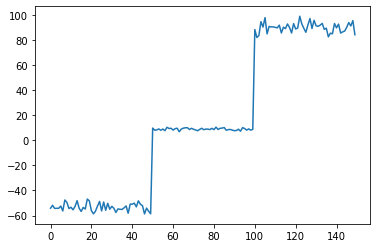

In [28]:
x = normal_random(50, 3, 100, 5)
plt.figure()
plt.plot(x)
plt.show()

In [71]:
@nb.njit(fastmath=True, nogil=True)
def pelt_segment(cost, max_cps, penalty, mbic):
    """Pruned exact linear time changepoint segmentation"""
    
    # Initializing parameters for segmentation
    n = cost.n
    
    # Initializing storage for costs and changepoints
    f = np.empty(n, dtype=np.float64)
    f[0] = -1 * penalty
    _costs = np.empty(n, dtype=np.float64)
    cps = np.zeros((n, max_cps), dtype=np.int64)
    r = np.empty(n, dtype=np.int64)
    r[0] = 0
    r_len = 1

    # Starting loop for search
    for tau_star in range(1, n):

        # Calculating each candidate cost
        for j in nb.prange(r_len):
            tau = r[j]
            _costs[j] = cost.cost(tau, tau_star) + f[tau] + penalty
            if mbic:
                _costs[j] += math.log(tau_star - tau)

        # Finding best candidate
        best_tau = np.argmin(_costs[: r_len])
        f[tau_star] = _costs[best_tau]
        best_r = r[best_tau]
        
        # Updating our changepoint array
        cps[tau_star, :] = cps[best_r, :]
        first_zero = np.argmin(cps[tau_star])
        cps[tau_star, first_zero] = best_r
        if tau_star == n - 1:
            break
        
        # Updating costs and prepping for next loop
        new_r_len = 0
        prune_cost = f[tau_star] + penalty
        for j in range(r_len):
            if _costs[j] <= prune_cost:
                r[new_r_len] = r[j]
                new_r_len += 1

        r[new_r_len] = tau_star
        r_len = new_r_len + 1
    
    # Getting final changepoints
    return np.append(cps[tau_star, : first_zero + 1], tau_star + 1)

In [72]:
pelt_segment(L2Cost().fit(x), 30, 250.0, True)

array([ 50, 100, 150], dtype=int64)

In [5]:
from pychange.costs import (_l1_cost)

In [31]:
_l1_cost.nopython_signatures[0].as_type()

FunctionType[float64(array(float64, 1d, A))]

In [6]:
_l1_cost.nopython_signatures[0].as_type()

FunctionType[float64(array(float64, 1d, A))]

In [12]:
import math
import numpy as np
import numba as nb
from pychange.costs import L1Cost
from pychange.penalties import mbic_penalty

@nb.njit(fastmath=True, nogil=True, parallel=True)
def binary_segment(data, cost, min_len, penalty_fn):
    """Runs binary segmentation on time series"""
    # TODO implement mbic

    # Setting up summary statistics and objects
    cost.fit(data)
    n = cost.n
    penalty = penalty_fn(n, cost.n_params)
    cps = np.empty(n, dtype=np.int64)
    cps[0] = n - 1
    n_cps = 1
    best_total_cost = cost.cost(0, n - 1)
    part_costs = np.empty(n, dtype=np.float64)
    part_costs[0] = best_total_cost

    # Initializing for out first run
    pre_part_cands = np.arange(max(min_len - 1, 1), n - min_len - 1)
    post_part_cands = np.empty(0, dtype=np.int64)
    cand_len = n - 2 * min_len
    pre_cps_start = 0
    pre_cps_end = n - 1
    post_cps_start = 0
    post_cps_end = n - 1
    pre_costs = 0.0
    post_costs = 0.0
    _pre_costs = np.empty(n, dtype=np.float64)
    _post_costs = np.empty(n, dtype=np.float64)
    _total_costs = np.full(n, fill_value=np.inf, dtype=np.float64)

    # Iterating through changepoints until convergence
    while True:

        # Checking if there are candidates within the last created partitions
        for i in nb.prange(pre_part_cands.size):

            # Calculating new partition costs
            _pre_cand = pre_part_cands[i]
            _pre_costs[_pre_cand] = cost.cost(pre_cps_start, _pre_cand)
            _post_costs[_pre_cand] = cost.cost(_pre_cand, pre_cps_end)
            _total_costs[_pre_cand] = _pre_costs[_pre_cand] + _post_costs[_pre_cand] + pre_costs

        # Checking if there are candidates within the last created partitions
        for i in nb.prange(post_part_cands.size):

            # Calculating new partition costs
            _post_cand = post_part_cands[i]
            _pre_costs[_post_cand] = cost.cost(post_cps_start, _post_cand)
            _post_costs[_post_cand] = cost.cost(_post_cand, post_cps_end)
            _total_costs[_post_cand] = _pre_costs[_post_cand] + _post_costs[_post_cand] + post_costs
        
        # Checking all candidates to compare against
        best_ind = np.argmin(_total_costs)
        best_cost = _total_costs[best_ind]

        # Checking if the new changepoint is worth it
        if best_cost >= best_total_cost - penalty:
            break

        # New changepoint detected
        cps[n_cps] = best_ind
        old_cost_sum = part_costs[: n_cps].sum()
        n_cps += 1
        sorted_inds = np.argsort(cps[: n_cps])
        new_cp_ind = np.argsort(sorted_inds)[n_cps - 1]
        cps[: n_cps] = cps[sorted_inds]
        part_costs[: n_cps] = part_costs[sorted_inds]
        pre_cp_ind = new_cp_ind - 1
        post_cp_ind = new_cp_ind + 1
        part_costs[new_cp_ind] = _pre_costs[best_ind]
        part_costs[post_cp_ind] = _post_costs[best_ind]

        # Setting values for next run
        if pre_cp_ind == -1:
            pre_cps_start = 0
        else:
            pre_cps_start = cps[pre_cp_ind]
        pre_cps_end = best_ind
        post_cps_start = best_ind
        post_cps_end = cps[post_cp_ind]
        cost_sum = part_costs[: n_cps].sum()
        cost_change = cost_sum - old_cost_sum
        pre_costs = cost_sum - part_costs[new_cp_ind]
        post_costs = cost_sum - part_costs[post_cp_ind]

        # Setting up new candidate arrays
        pre_part_cands = np.arange(pre_cps_start + min_len, pre_cps_end - min_len)
        post_part_cands = np.arange(post_cps_start + min_len, post_cps_end - min_len)

        # Updating total cost change with outer partitions
        _total_costs[: pre_cps_start] += cost_change
        _total_costs[post_cps_end: ] += cost_change
        _total_costs[best_ind - min_len: best_ind + min_len] = np.inf
        best_total_cost = best_cost

    return cps[: n_cps]

In [13]:
# Setting hyperparams
min_len = 1
k = 20
pen = 100.0
mbic = False
max_cps = 50
n_runs = 5
seg_len = 1000
n_cps = 3

def normal_random(seg_len, n_cps, loc_limit=10, scale_var=5):
    loc = np.random.uniform(-1 * loc_limit, loc_limit, size=(n_cps + 1,))
    scale = np.random.uniform(0, scale_var, size=(n_cps + 1,))
    return np.random.normal(loc, scale, size=(seg_len, n_cps + 1)).flatten('F')

data = normal_random(seg_len, n_cps)

In [14]:
binary_segment.py_func(data, L1Cost(), min_len, mbic_penalty)

array([1000, 2002, 3001, 3999], dtype=int64)

In [23]:
_l1_cost.nopython_signatures[0].__dir__()

['__module__',
 '__doc__',
 '__slots__',
 '__init__',
 'return_type',
 'args',
 'recvr',
 'pysig',
 'replace',
 '__getstate__',
 '__setstate__',
 '__hash__',
 '__eq__',
 '__ne__',
 '__repr__',
 'is_method',
 'as_method',
 'as_function',
 'as_type',
 '__unliteral__',
 'dump',
 'is_precise',
 '_args',
 '_pysig',
 '_recvr',
 '_return_type',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [79]:
def poisson_random(seg_len, n_cps, lam_var):
    lam = np.random.uniform(0, lam_var, size=(n_cps,))
    return np.random.poisson(lam, size=(seg_len, n_cps)).flatten('F')

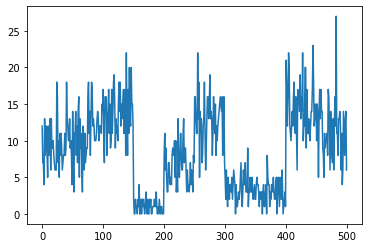

In [80]:
x = poisson_random(50, 10, 15)
plt.figure()
plt.plot(x)
plt.show()

In [81]:
def exp_random(seg_len, n_cps, scale_var):
    scale = np.random.uniform(0, scale_var, size=(n_cps,))
    return np.random.exponential(scale, size=(seg_len, n_cps)).flatten('F')

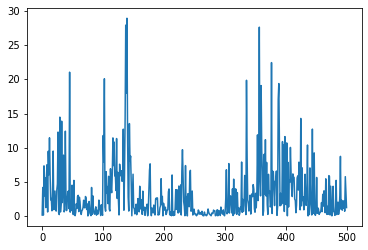

In [84]:
x = exp_random(50, 10, 10)
plt.figure()
plt.plot(x)
plt.show()

In [89]:
def gamma_random(seg_len, n_cps, shape_var):
    shape = np.random.uniform(0, shape_var, size=(n_cps,))
    return np.random.gamma(shape, size=(seg_len, n_cps)).flatten('F')

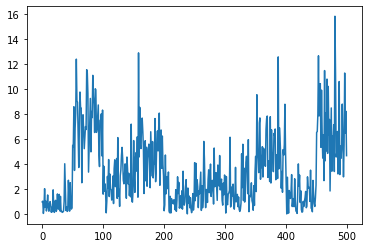

In [91]:
x = gamma_random(50, 10, 10)
plt.figure()
plt.plot(x)
plt.show()

In [ ]:
import math
import numba as nb

In [ ]:
cost = L1Cost().fit(x)

In [95]:
@nb.njit(['f8(i8, i8)'], fastmath=True)
def mbic_penalty(n, n_params):
    return (n_params + 2) * math.log(n)

In [96]:
mbic_penalty(100, 1)

13.815510557964275

In [2]:
# Creating Normal synthetic data
size = 10000
sm_size = 100
k = 20
min_len = 10
max_cp = 40
pen = 100.0
test_series = np.hstack([np.random.normal(0, 1, (size,)),
                         np.random.normal(6, 1, (size,)),
                         np.random.normal(0, 2, (size,)),
                         np.random.normal(-4, 1, (size,)),
                         np.random.normal(3, 1, (size,)),
                         ])

sm_test_series = np.hstack([np.random.normal(0, 1, (sm_size,)),
                         np.random.normal(6, 1, (sm_size,)),
                         np.random.normal(0, 2, (sm_size,)),
                         #np.random.normal(-4, 1, (sm_size,)),
                         #np.random.normal(3, 1, (sm_size,)),
                         ])

p_test_series = np.hstack([np.random.poisson(2, (size,)),
                         np.random.poisson(6, (size,)),
                         np.random.poisson(10, (size,)),
                         np.random.poisson(4, (size,)),
                         np.random.poisson(3, (size,)),
                         ] * 8)

g_test_series = p_test_series + 1

In [7]:
n, dim = 500, 1  # number of samples, dimension
n_bkps, sigma = 3, 5  # number of change points, noise standard deviation
rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)[0].flatten()

array([ 7.12219515e+00,  6.09201119e+00,  1.63738703e+00,  5.38984560e+00,
        7.22748963e+00,  9.48169187e+00,  2.05098534e+01,  4.19961881e+00,
        1.17356297e+00, -1.14340939e+00,  2.61465373e+00,  6.09640023e+00,
        5.10883106e+00,  7.60876175e+00,  2.13519203e+00,  2.10872135e+00,
        7.75136365e+00,  8.54875591e+00,  6.49592124e+00,  7.71949140e+00,
        3.59249447e+00,  1.03430539e+01, -3.89346511e+00, -1.39921471e+00,
        6.71308927e+00,  3.86507755e+00,  2.07276121e+00,  2.91815098e+00,
        7.72756115e+00,  4.33937405e+00, -4.53194369e+00,  2.90157441e+00,
        5.22776353e+00, -4.48852401e+00, -4.11593850e+00,  5.71070924e+00,
        9.06463091e-01,  6.49710786e+00,  1.48682529e+01,  6.17934055e+00,
        7.67042725e+00,  3.97727402e+00,  9.80302046e+00,  1.82717039e+00,
       -5.55466540e+00,  7.03202759e+00,  6.38962011e+00,  3.83172148e+00,
        3.66983254e+00,  5.94627936e+00,  1.52976331e+01,  8.55626407e+00,
        1.12569328e+01, -

In [4]:
signal

array([[ 5.97104038],
       [11.06564127],
       [10.96544683],
       [ 4.04531675],
       [ 0.74845227],
       [11.40047447],
       [ 5.79008208],
       [-3.33085796],
       [ 0.24907088],
       [12.37250433],
       [ 2.81406155],
       [ 2.14767701],
       [10.4688779 ],
       [ 8.82297347],
       [ 7.37284854],
       [ 3.49691213],
       [ 3.21430637],
       [ 4.51280863],
       [ 0.49077039],
       [ 5.92243911],
       [ 6.48017219],
       [ 8.75645762],
       [ 5.44279274],
       [11.76180014],
       [ 0.96014415],
       [16.4606271 ],
       [-0.08395265],
       [12.69441133],
       [ 4.06485283],
       [12.69725566],
       [ 9.64909483],
       [ 1.39765268],
       [ 9.18338509],
       [ 8.1611064 ],
       [ 5.80190088],
       [ 4.85432779],
       [ 5.29900827],
       [ 8.51673562],
       [ 5.33020661],
       [ 7.72391365],
       [ 5.58560989],
       [-1.05822134],
       [ 2.31116445],
       [ 0.21664374],
       [-1.33282095],
       [10

In [9]:
# MBIC testing
x = np.hstack([np.random.poisson(2, (sm_size,)),
                         np.random.poisson(6, (sm_size,)),
                         np.random.poisson(10, (sm_size,)),
                         np.random.poisson(4, (sm_size,)),
                         np.random.poisson(3, (sm_size,)),
                         ]) + 1
x = x.astype(np.float64)
test_classes = [L1Cost,
                L2Cost,
                NormalMeanCost,
                NormalVarCost,
                NormalMeanVarCost,
                PoissonMeanVarCost,
                ExponentialMeanVarCost,
                GammaMeanVarCost,
                EmpiricalCost]
for i in test_classes:
    print(i)
    print(amoc_segment(i().fit(x), min_len, pen, True))
    print(amoc_segment(i().fit(x), min_len, pen, True))

<class 'numba.experimental.jitclass.base.L1Cost'>


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m- Resolution failure for literal arguments:
[1mFailed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.CallConstraint object at 0x000001BEB3F5B880>.
[1m[1m[1mtoo many positional arguments[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _l1_cost at 0x000001BEA588F940>))[0m
[0m[1mDuring: typing of call at C:\Users\jgursky\Documents\GitHub\pychange\pychange\costs.py (22)
[0m
Enable logging at debug level for details.
[1m
File "pychange\costs.py", line 22:[0m
[1m    def cost(self, start, end):
[1m        return _l1_cost(self.y[start: end], start, end)
[0m        [1m^[0m[0m
[0m
[0m[1m- Resolution failure for non-literal arguments:
[1mFailed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.CallConstraint object at 0x000001BEB4095160>.
[1m[1m[1mtoo many positional arguments[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _l1_cost at 0x000001BEA588F940>))[0m
[0m[1mDuring: typing of call at C:\Users\jgursky\Documents\GitHub\pychange\pychange\costs.py (22)
[0m
Enable logging at debug level for details.
[1m
File "pychange\costs.py", line 22:[0m
[1m    def cost(self, start, end):
[1m        return _l1_cost(self.y[start: end], start, end)
[0m        [1m^[0m[0m
[0m
[0m[0m
[0m[1mDuring: resolving callee type: BoundFunction((<class 'numba.core.types.misc.ClassInstanceType'>, 'cost') for instance.jitclass.L1Cost#1bea570fdc0<n:int64,mbic:bool,y:array(float64, 1d, A)>)[0m
[0m[1mDuring: typing of call at C:\Users\jgursky\Documents\GitHub\pychange\pychange\segment.py (13)
[0m
[1m
File "pychange\segment.py", line 13:[0m
[1mdef amoc_segment(cost, min_len, penalty, mbic):
    <source elided>
    for i in nb.prange(min_len, n - min_len):
[1m        pre_cost = cost.cost(0, i) + penalty
[0m        [1m^[0m[0m


# AMOC

## Normal Mean

In [3]:
# Normal mean
amoc_segment(NormalMeanCost().fit(test_series), min_len, pen)

6000

In [5]:
# Normal mean
amoc_segment_parallel(NormalMeanCost().fit(test_series), min_len, pen)

6003

In [6]:
ROfflineChangepoint('mean', penalty='Manual', pen_value=pen, method='AMOC', minseglen=min_len).fit(test_series).predict()

array([6003.])

In [7]:
# Pychange Timing
%timeit amoc_segment(NormalMeanCost().fit(test_series), min_len, pen)

2.22 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
# R timing
%timeit ROfflineChangepoint('mean', penalty='Manual', pen_value=pen, method='AMOC', test_stat="Normal", minseglen=min_len).fit(test_series).predict()

12.6 ms ± 445 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
# Pychange Timing
%timeit amoc_segment_parallel(NormalMeanCost().fit(test_series), min_len, pen)

658 µs ± 45.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Normal Var

In [27]:
# Normal mean
amoc_segment(NormalVarCost().fit(test_series), min_len, pen)

10000

In [28]:
ROfflineChangepoint('var', penalty='Manual', pen_value=pen, method='AMOC', minseglen=min_len).fit(test_series).predict()

array([10000.])

In [29]:
# Pychange Timing
%timeit amoc_segment(NormalVarCost().fit(test_series), min_len, pen)

22.9 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
# R timing
%timeit ROfflineChangepoint('var', penalty='Manual', pen_value=pen, method='AMOC', test_stat="Normal", minseglen=min_len).fit(test_series).predict()

48.4 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Normal Mean+Var

In [10]:
# Normal mean
amoc_segment(NormalMeanVarCost().fit(test_series), min_len, pen)

117000

In [11]:
ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='AMOC', minseglen=min_len).fit(test_series).predict()

array([117000.])

In [13]:
# Normal mean
amoc_segment_parallel(NormalMeanVarCostFast().fit(test_series), min_len, pen)

117000

In [14]:
# Pychange Timing
%timeit amoc_segment(NormalMeanVarCost().fit(test_series), min_len, pen)

3.88 ms ± 79.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
# R timing
%timeit ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='AMOC', test_stat="Normal", minseglen=min_len).fit(test_series).predict()

23 ms ± 680 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit amoc_segment_parallel(NormalMeanVarCostFast().fit(test_series), min_len, pen)

1.21 ms ± 37.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Poisson Mean+Var

In [35]:
# Normal mean
amoc_segment(PoissonMeanVarCost().fit(p_test_series), min_len, pen)

10000

In [36]:
ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='AMOC', test_stat="Poisson", minseglen=min_len).fit(p_test_series).predict()

array([10000.])

In [37]:
# Pychange Timing
%timeit amoc_segment(PoissonMeanVarCost().fit(p_test_series), min_len, pen)

12 ms ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
# R timing
%timeit ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='AMOC', test_stat="Poisson", minseglen=min_len).fit(p_test_series).predict()

262 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Exponential

In [3]:
amoc_segment(ExponentialMeanVarCost().fit(p_test_series), min_len, pen)

10000

In [4]:
ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='AMOC', test_stat="Exponential", minseglen=min_len).fit(p_test_series).predict()

array([10000.])

In [5]:
%timeit amoc_segment(ExponentialMeanVarCost().fit(p_test_series), min_len, pen)

11.5 ms ± 75.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%timeit ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='AMOC', test_stat="Exponential", minseglen=min_len).fit(p_test_series).predict()

254 ms ± 6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Gamma

In [3]:
amoc_segment(GammaMeanVarCost().fit(g_test_series), min_len, pen)

10000

In [4]:
ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='AMOC', test_stat="Gamma", minseglen=min_len).fit(g_test_series).predict()

array([10000.])

In [5]:
%timeit amoc_segment(GammaMeanVarCost().fit(g_test_series), min_len, pen)

11.4 ms ± 44.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%timeit ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='AMOC', test_stat="Gamma", minseglen=min_len).fit(g_test_series).predict()

246 ms ± 8.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Nonparametric

In [17]:
# Normal mean
amoc_segment(NonParametricCost(k).fit(test_series), min_len, pen)

6003

In [18]:
# Pychange Timing
%timeit amoc_segment(NonParametricCost(k).fit(test_series), min_len, pen)

117 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
# Normal mean
amoc_segment_parallel(NonParametricCost(k).fit(test_series), min_len, pen)

6003

In [21]:
# Pychange Timing
%timeit amoc_segment_parallel(NonParametricCost(k).fit(test_series), min_len, pen)

54.2 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
# Normal mean
amoc_segment(NonParametricCostParallel(k).fit(test_series), min_len, pen)

6003

In [23]:
# Pychange Timing
%timeit amoc_segment(NonParametricCostParallel(k).fit(test_series), min_len, pen)

62.6 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
# Normal mean
amoc_segment_parallel(NonParametricCostParallel(k).fit(test_series), min_len, pen)

6003

In [25]:
# Pychange Timing
%timeit amoc_segment_parallel(NonParametricCostParallel(k).fit(test_series), min_len, pen)

30 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Pelt

## L1

In [41]:
# L1 cost
pelt_segment(L1Cost().fit(sm_test_series), min_len, max_cp, pen, 1)

array([100, 200, 300, 400], dtype=int64)

In [42]:
rpt.Pelt(model='l1', min_size=min_len, jump=1).fit(sm_test_series).predict(pen=pen)

[100, 200, 300, 400, 500]

In [43]:
%timeit pelt_segment(L1Cost().fit(sm_test_series), min_len, max_cp, pen, 1)

37.5 ms ± 36.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%timeit rpt.Pelt(model='l1', min_size=min_len, jump=1).fit(sm_test_series).predict(pen=pen)

2.22 s ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## L2

In [45]:
# L1 cost
pelt_segment(L2Cost().fit(sm_test_series), min_len, max_cp, pen, 1)

array([100, 200, 300, 400], dtype=int64)

In [46]:
rpt.Pelt(model='l2', min_size=min_len, jump=1).fit(sm_test_series).predict(pen=pen)

[100, 200, 300, 400, 500]

In [47]:
%timeit pelt_segment(L2Cost().fit(sm_test_series), min_len, max_cp, pen, 1)

1.8 ms ± 579 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [48]:
%timeit rpt.Pelt(model='l2', min_size=min_len, jump=1).fit(sm_test_series).predict(pen=pen)

700 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Normal Mean

In [9]:
# Normal mean
pelt_segment(NormalMeanCost().fit(test_series), min_len, max_cp, pen, 1)

array([ 2500,  5001,  7500, 10000, 12500, 15000, 17501, 20000, 22500,
       25000, 27500, 30001, 32500, 35000, 37500, 40000, 42501, 45000,
       47500, 50000, 52500, 55001, 57500, 60000, 62500, 65000, 67501,
       70000, 72500, 75000, 77500, 80001, 82500, 85000, 87500, 90000,
       92501, 95000, 97500], dtype=int64)

In [10]:
# Normal mean
pelt_segment_parallel(NormalMeanCost().fit(test_series), min_len, max_cp, pen, 1)

array([ 2500,  5001,  7500, 10000, 12500, 15000, 17501, 20000, 22500,
       25000, 27500, 30001, 32500, 35000, 37500, 40000, 42501, 45000,
       47500, 50000, 52500, 55001, 57500, 60000, 62500, 65000, 67501,
       70000, 72500, 75000, 77500, 80001, 82500, 85000, 87500, 90000,
       92501, 95000, 97500], dtype=int64)

In [11]:
ROfflineChangepoint('mean', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len).fit(test_series).predict()

array([ 2500,  5001,  7500, 10000, 12500, 15000, 17501, 20000, 22500,
       25000, 27500, 30001, 32500, 35000, 37500, 40000, 42501, 45000,
       47500, 50000, 52500, 55001, 57500, 60000, 62500, 65000, 67501,
       70000, 72500, 75000, 77500, 80001, 82500, 85000, 87500, 90000,
       92501, 95000, 97500], dtype=int32)

In [12]:
# Pychange Timing
%timeit pelt_segment(NormalMeanCost().fit(test_series), min_len, max_cp, pen, 1)

1.97 s ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# R timing
%timeit ROfflineChangepoint('mean', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len).fit(test_series).predict()

555 ms ± 790 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
# Normal mean
%timeit pelt_segment_parallel(NormalMeanCost().fit(test_series), min_len, max_cp, pen, 1)

1.93 s ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Normal Var

In [53]:
pelt_segment(NormalVarCost().fit(test_series), min_len, max_cp, pen, 1)

array([   671,    707,  10000,  20001,  29999,  40000,  50013,  50671,
        50707,  60000,  70001,  79999,  90000, 100013, 100671, 100707,
       110000, 120001, 129999, 140000, 150013, 150671, 150707, 160000,
       170001, 179999, 190000, 200013, 200671, 200707, 210000, 220001,
       229999, 240000, 250013, 250671, 250707, 260000, 270001, 279999,
       290000, 300013, 300671, 300707, 310000, 320001, 329999, 340000,
       350013, 350671, 350707, 360000, 370001, 379999, 390000],
      dtype=int64)

In [54]:
ROfflineChangepoint('var', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len).fit(test_series).predict()

array([ 10000,  20001,  29999,  40000,  50007,  60000,  70001,  79999,
        90000, 100007, 110000, 120001, 129999, 140000, 150007, 160000,
       170001, 179999, 190000, 200007, 210000, 220001, 229999, 240000,
       250007, 260000, 270001, 279999, 290000, 300007, 310000, 320001,
       329999, 340000, 350007, 360000, 370001, 379999, 390000],
      dtype=int32)

In [55]:
# Pychange Timing
%timeit pelt_segment(NormalVarCost().fit(test_series), min_len, max_cp, pen, 1)

49.5 s ± 427 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
# R timing
%timeit ROfflineChangepoint('var', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len).fit(test_series).predict()

1min 13s ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Normal Mean+Var

In [26]:
pelt_segment(NormalMeanVarCost().fit(test_series), min_len, max_cp, pen, 1)

array([  3000,   6000,   9000,  12000,  15000,  18000,  21000,  24000,
        27000,  30000,  33000,  36000,  39000,  42000,  45000,  48000,
        51000,  54000,  57000,  60000,  63000,  66000,  69000,  72000,
        75000,  78000,  81000,  84000,  87000,  90000,  93000,  96000,
        99000, 102000, 105000, 108000, 111000, 114000, 117000],
      dtype=int64)

In [27]:
pelt_segment_parallel(NormalMeanVarCostFast().fit(test_series), min_len, max_cp, pen, 1)

array([  3000,   6000,   9000,  12000,  15000,  18000,  21000,  24000,
        27000,  30000,  33000,  36000,  39000,  42000,  45000,  48000,
        51000,  54000,  57000,  60000,  63000,  66000,  69000,  72000,
        75000,  78000,  81000,  84000,  87000,  90000,  93000,  96000,
        99000, 102000, 105000, 108000, 111000, 114000, 117000],
      dtype=int64)

In [28]:
ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len).fit(test_series).predict()

array([  3000,   6000,   9000,  12000,  15000,  18000,  21000,  24000,
        27000,  30000,  33000,  36000,  39000,  42000,  45000,  48000,
        51000,  54000,  57000,  60000,  63000,  66000,  69000,  72000,
        75000,  78000,  81000,  84000,  87000,  90000,  93000,  96000,
        99000, 102000, 105000, 108000, 111000, 114000, 117000],
      dtype=int32)

In [29]:
# Pychange Timing
%timeit pelt_segment(NormalMeanVarCost().fit(test_series), min_len, max_cp, pen, 1)

4.53 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
# R timing
%timeit ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len).fit(test_series).predict()

6.77 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
# Pychange Timing
%timeit pelt_segment_parallel(NormalMeanVarCostFast().fit(test_series), min_len, max_cp, pen, 1)

4.03 s ± 52.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Poisson Mean+Var

In [61]:
pelt_segment(PoissonMeanVarCost().fit(p_test_series), min_len, max_cp, pen, 1)

array([ 10000,  19998,  30000,  39998,  50000,  60000,  69998,  80000,
        89998, 100000, 110000, 119998, 130000, 139998, 150000, 160000,
       169998, 180000, 189998, 200000, 210000, 219998, 230000, 239998,
       250000, 260000, 269998, 280000, 289998, 300000, 310000, 319998,
       330000, 339998, 350000, 360000, 369998, 380000, 389998],
      dtype=int64)

In [62]:
ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len, test_stat="Poisson").fit(p_test_series).predict()

array([ 10000,  19998,  30000,  39998,  50000,  60000,  69998,  80000,
        89998, 100000, 110000, 119998, 130000, 139998, 150000, 160000,
       169998, 180000, 189998, 200000, 210000, 219998, 230000, 239998,
       250000, 260000, 269998, 280000, 289998, 300000, 310000, 319998,
       330000, 339998, 350000, 360000, 369998, 380000, 389998],
      dtype=int32)

In [ ]:
# Pychange Timing
%timeit pelt_segment(PoissonMeanVarCost().fit(p_test_series), min_len, max_cp, pen, 1)

In [ ]:
# R timing
%timeit ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len, test_stat="Poisson").fit(p_test_series).predict()

## Exponential Mean+Var

In [7]:
pelt_segment(ExponentialMeanVarCost().fit(p_test_series), min_len, max_cp, pen, 1)

array([ 10000,  19998,  30000,  39997,  50013,  60000,  69998,  80000,
        89997, 100013, 110000, 119998, 130000, 139997, 150013, 160000,
       169998, 180000, 189997, 200013, 210000, 219998, 230000, 239997,
       250013, 260000, 269998, 280000, 289997, 300013, 310000, 319998,
       330000, 339997, 350013, 360000, 369998, 380000, 389997],
      dtype=int64)

In [ ]:
ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len, test_stat="Exponential").fit(p_test_series).predict()

Exception ignored from cffi callback <function _callback at 0x0000013DEEEF10D0>:
Traceback (most recent call last):
  File "C:\Users\15072\anaconda3\envs\pychange\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 313, in _callback
    try:
KeyboardInterrupt: 


In [ ]:
# Pychange Timing
%timeit pelt_segment(ExponentialMeanVarCost().fit(p_test_series), min_len, max_cp, pen, 1)

In [ ]:
# R timing
%timeit ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len, test_stat="Exponential").fit(p_test_series).predict()

## Gamma Mean+Var

In [ ]:
pelt_segment(GammaMeanVarCost().fit(g_test_series), min_len, max_cp, pen, 1)

In [ ]:
ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len, test_stat="Gamma").fit(g_test_series).predict()

In [ ]:
# Pychange Timing
%timeit pelt_segment(GammaMeanVarCost().fit(g_test_series), min_len, max_cp, pen, 1)

In [ ]:
# R timing
%timeit ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len, test_stat="Gamma").fit(g_test_series).predict().predict()

## Nonparametric

In [3]:
pelt_segment(NonParametricCost(k).fit(sm_test_series), min_len, max_cp, pen, 1)

array([ 400,  800, 1200, 1600], dtype=int64)

In [4]:
ROfflineChangepoint('np', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len, nquantiles=k).fit(sm_test_series).predict()

array([ 400,  800, 1200, 1600], dtype=int32)

In [5]:
# Pychange Timing
%timeit pelt_segment(NonParametricCost(k).fit(sm_test_series), min_len, max_cp, pen, 1)

66.3 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
# R timing
%timeit ROfflineChangepoint('np', penalty='Manual', pen_value=pen, method='PELT', minseglen=min_len, nquantiles=k).fit(sm_test_series).predict()

461 ms ± 8.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
pelt_segment_parallel(NonParametricCostParallel(k).fit(sm_test_series), min_len, max_cp, pen, 1)

array([ 400,  800, 1200, 1600], dtype=int64)

In [8]:
# Pychange Timing
%timeit pelt_segment_parallel(NonParametricCostParallel(k).fit(sm_test_series), min_len, max_cp, pen, 1)

78.1 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Binary Segmentation

## L1

In [ ]:
# L1 cost
binary_segment(L1Cost().fit(sm_test_series), min_len, pen)

In [ ]:
rpt.Binseg(model='l1', min_size=min_len, jump=1).fit(sm_test_series).predict(pen=pen)

In [ ]:
%timeit binary_segment(L1Cost().fit(sm_test_series), min_len, pen)

In [ ]:
%timeit rpt.Binseg(model='l1', min_size=min_len, jump=1).fit(sm_test_series).predict(pen=pen)

## L2

In [ ]:
# L2 cost
binary_segment(L2Cost().fit(sm_test_series), min_len, pen)

In [ ]:
rpt.Binseg(model='l2', min_size=min_len, jump=1).fit(sm_test_series).predict(pen=pen)

In [ ]:
%timeit binary_segment(L2Cost().fit(sm_test_series), min_len, pen)

In [ ]:
%timeit rpt.Binseg(model='l2', min_size=min_len, jump=1).fit(sm_test_series).predict(pen=pen)

## Normal Mean

In [3]:
# Normal mean
binary_segment(NormalMeanCost().fit(test_series), min_len, pen)

array([ 2000,  4002,  5999,  8000, 10000, 12000, 14002, 15999, 18000,
       20000, 22000, 24002, 25999, 28000, 30000, 32000, 34002, 35999,
       38000, 40000, 42000, 44002, 45999, 48000, 50000, 52000, 54002,
       55999, 58000, 60000, 62000, 64002, 65999, 68000, 70000, 72000,
       74002, 75999, 78000, 79999], dtype=int64)

In [4]:
# Normal mean
binary_segment_parallel(NormalMeanCost().fit(test_series), min_len, pen)

array([ 2000,  4002,  5999,  8000, 10000, 12000, 14002, 15999, 18000,
       20000, 22000, 24002, 25999, 28000, 30000, 32000, 34002, 35999,
       38000, 40000, 42000, 44002, 45999, 48000, 50000, 52000, 54002,
       55999, 58000, 60000, 62000, 64002, 65999, 68000, 70000, 72000,
       74002, 75999, 78000, 79999], dtype=int64)

In [5]:
ROfflineChangepoint('mean', penalty='Manual', pen_value=pen, method='BinSeg', minseglen=min_len, Q=100).fit(test_series).predict()

array([ 2000.,  4002.,  5999.,  8000., 10000., 12000., 14002., 15999.,
       18000., 20000., 22000., 24002., 25999., 28000., 30000., 32000.,
       34002., 35999., 38000., 40000., 42000., 44002., 45999., 48000.,
       50000., 52000., 54002., 55999., 58000., 60000., 62000., 64002.,
       65999., 68000., 70000., 72000., 74002., 75999., 78000.])

In [6]:
# Pychange Timing
%timeit binary_segment(NormalMeanCost().fit(test_series), min_len, pen)

19.1 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# R timing
%timeit ROfflineChangepoint('mean', penalty='Manual', pen_value=pen, method='BinSeg', minseglen=min_len, Q=100).fit(test_series).predict()

55.4 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit binary_segment_parallel(NormalMeanCost().fit(test_series), min_len, pen)

18.1 ms ± 71 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Normal Var

In [ ]:
# Normal mean
binary_segment(NormalVarCost().fit(test_series), min_len, pen)

In [ ]:
ROfflineChangepoint('var', penalty='Manual', pen_value=pen, method='BinSeg', minseglen=min_len, Q=100).fit(test_series).predict()

In [ ]:
# Pychange Timing
%timeit binary_segment(NormalVarCost().fit(test_series), min_len, pen)

In [ ]:
# R timing
%timeit ROfflineChangepoint('var', penalty='Manual', pen_value=pen, method='BinSeg', minseglen=min_len, Q=100).fit(test_series).predict()

## Normal Mean+Var

In [9]:
# Normal mean
binary_segment(NormalMeanVarCost().fit(sm_test_series), min_len, pen)

array([ 400,  800, 1200, 1600, 1999], dtype=int64)

In [10]:
binary_segment_parallel(NormalMeanVarCostFast().fit(sm_test_series), min_len, pen)

array([ 400,  800, 1200, 1600, 1999], dtype=int64)

In [11]:
ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='BinSeg', minseglen=min_len, Q=100).fit(sm_test_series).predict()

array([ 400.,  800., 1200., 1600.])

In [12]:
# Pychange Timing
%timeit binary_segment(NormalMeanVarCost().fit(sm_test_series), min_len, pen)

309 µs ± 7.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
# R timing
%timeit ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='BinSeg', minseglen=min_len, Q=100).fit(sm_test_series).predict()

9.96 ms ± 63.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%timeit binary_segment_parallel(NormalMeanVarCostFast().fit(sm_test_series), min_len, pen)

3.26 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit rpt.Binseg(model='normal', min_size=min_len, jump=1).fit(sm_test_series).predict(pen=pen)

485 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Poisson Mean+Var

In [ ]:
# Normal mean
binary_segment(PoissonMeanVarCost().fit(p_test_series), min_len, pen)

In [ ]:
ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='BinSeg', minseglen=min_len, test_stat='Poisson', Q=100).fit(p_test_series).predict()

In [ ]:
# Pychange Timing
%timeit binary_segment(PoissonMeanVarCost().fit(p_test_series), min_len, pen)

In [ ]:
# R timing
%timeit ROfflineChangepoint('meanvar', penalty='Manual', pen_value=pen, method='BinSeg', minseglen=min_len, test_stat='Poisson', Q=100).fit(p_test_series).predict()

# Bayesian Online Changepoint

In [ ]:
OnlineCP(ConstantHazard(), StudentTProb(), 10, 0.5).update(sm_test_series).get_cps()

In [7]:
ROCP().fit(sm_test_series).predict()

array([101, 201], dtype=int64)

In [8]:
%timeit OnlineCP(ConstantHazard(), StudentTProb(), 5, 0.5).update(sm_test_series).get_cps()

12.4 ms ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit ROCP().fit(sm_test_series).predict()

136 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
